In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Colorization Using Autoencoders and Resnet

This notebook is an attempt to colorize grayscale images using deep learning. While I originally played around with this idea using an autoencoder and my own steam, I switched to the trying technique discribed in this article: https://medium.freecodecamp.org/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d

In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf
import glob

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Read in Data


In [0]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)
TRAIN_PATH = '/content/drive/My Drive/Projet DataScience/Data/Train/dataset_clean_degraded/clean/'


In [16]:
cd '..'

/


In [0]:
X_train = []
filenames = os.listdir(TRAIN_PATH)
filenames = filenames[:20]

for filename in filenames:
  img = imread(TRAIN_PATH + filename)
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_train.append(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


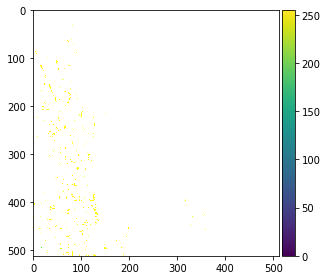

In [18]:
imshow(X_train[10])
plt.show()

# Train/Test Split
Just getting a sample of 20 images to test the model when it is done.

In [0]:
X_train, X_test = train_test_split(X_train, test_size=2, random_state=seed)

# Create the Model

The model is a combination of an autoencoder and resnet classifier. The best an autoencoder by itself is just shade everything in a brownish tone. The model uses an resnet classifier to give the neural network an "idea" of what things should be colored.

In [21]:
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('../input/inception-resnet-v2-weights/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()

OSError: ignored

In [26]:
def Colorize():
    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

model = Colorize()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 256, 256, 128 1280        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 128 0           conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 128, 128, 128 262272      max_pooling2d_5[0][0]            
__________________________________________________________________________________________

# Data Generator Functions

In [27]:
%%time

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Create embedding
def create_inception_embedding(grayscaled_rgb):
    def resize_gray(x):
        return resize(x, (299, 299, 3), mode='constant')
    grayscaled_rgb_resized = np.array([resize_gray(x) for x in grayscaled_rgb])
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

#Generate training data
def image_a_b_gen(dataset=X_train, batch_size = 20):
    for batch in datagen.flow(dataset, batch_size=batch_size):
        X_batch = rgb2gray(batch)
        grayscaled_rgb = gray2rgb(X_batch)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield [X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch
        

CPU times: user 217 µs, sys: 0 ns, total: 217 µs
Wall time: 245 µs


# Checkpoints

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)
filepath = "Art_Colorization_Model.h5"
checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='loss',
                             mode='min')

model_callbacks = [learning_rate_reduction,checkpoint]

# Train the Model

In [31]:
%%time
BATCH_SIZE = 3
model.fit(image_a_b_gen(X_train,BATCH_SIZE),
            epochs=30,
            verbose=1,
            steps_per_epoch=2,
             callbacks=model_callbacks
                   )

Epoch 1/30


ValueError: ignored

In [0]:
model.save(filepath)
model.save_weights("Art_Colorization_Weights.h5")

# Sample the Results

In [0]:
sample = X_test
color_me = gray2rgb(rgb2gray(sample))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = model.predict([color_me, color_me_embed])
output = output * 128

decoded_imgs = np.zeros((len(output),256, 256, 3))

for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    decoded_imgs[i] = lab2rgb(cur)
    cv2.imwrite("img_"+str(i)+".jpg", lab2rgb(cur))

In [0]:
plt.figure(figsize=(20, 6))
for i in range(10):
    # grayscale
    plt.subplot(3, 10, i + 1)
    plt.imshow(rgb2gray(X_test)[i].reshape(256, 256))
    plt.gray()
    plt.axis('off')
 
    # recolorization
    plt.subplot(3, 10, i + 1 +10)
    plt.imshow(decoded_imgs[i].reshape(256, 256,3))
    plt.axis('off')
    
    # original
    plt.subplot(3, 10, i + 1 + 20)
    plt.imshow(X_test[i].reshape(256, 256,3))
    plt.axis('off')
 
plt.tight_layout()
plt.show()